<h2 style='background:blue; border:0; color:white'><center>Investigation on the Impact of Optimizer and Learning Rate on the Recall and Convergence of Deep Learning Model for Insurance Cross-Selling </center><h2>




<h3 style='background:blue; border:0; color:white'><center>Introduction:</center><h3>

<h3 style='background:blue; border:0; color:white'><center>The insurance industry has seen a rapid increase in the adoption of deep learning techniques to drive their cross-selling strategies. The goal of this project is to explore the impact of optimizer , learning rate and batch size on the accuracy and convergence of a deep learning model designed to support an insurance company's cross-selling strategy. </center><h3>


<h3 style='background:blue; border:0; color:white'><center>We used the recall score as our metrics , because we would like to minimize the false negative result and enhance the true positive result so as to upselling more customers to buy the vehicle insurance. </center><h3>



In [ ]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import matplotlib.pyplot as plt

import seaborn as sns

##import optuna
##from optuna.samplers import TPESampler

#from pyod.models.copod import COPOD

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [ ]:
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

<a id="2"></a>
<h2 style='background:blue; border:0; color:white'><center>2. Feature Engineering</center><h2>

1) Convert columns with text values

In [ ]:
train.loc[train['Gender'] == 'Male', 'Gender'] = 1
train.loc[train['Gender'] == 'Female', 'Gender'] = 0
test.loc[test['Gender'] == 'Male', 'Gender'] = 1
test.loc[test['Gender'] == 'Female', 'Gender'] = 0

train.loc[train['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
train.loc[train['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
train.loc[train['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0
test.loc[test['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
test.loc[test['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
test.loc[test['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0

train.loc[train['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1
train.loc[train['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0
test.loc[test['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1
test.loc[test['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0

In [ ]:
for col in train.columns:
    train[col] = train[col].astype(np.float32)

train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1.0,44.0,1.0,28.0,0.0,2.0,1.0,40454.0,26.0,217.0,1.0
1,1.0,76.0,1.0,3.0,0.0,1.0,0.0,33536.0,26.0,183.0,0.0
2,1.0,47.0,1.0,28.0,0.0,2.0,1.0,38294.0,26.0,27.0,1.0
3,1.0,21.0,1.0,11.0,1.0,0.0,0.0,28619.0,152.0,203.0,0.0
4,0.0,29.0,1.0,41.0,1.0,0.0,0.0,27496.0,152.0,39.0,0.0


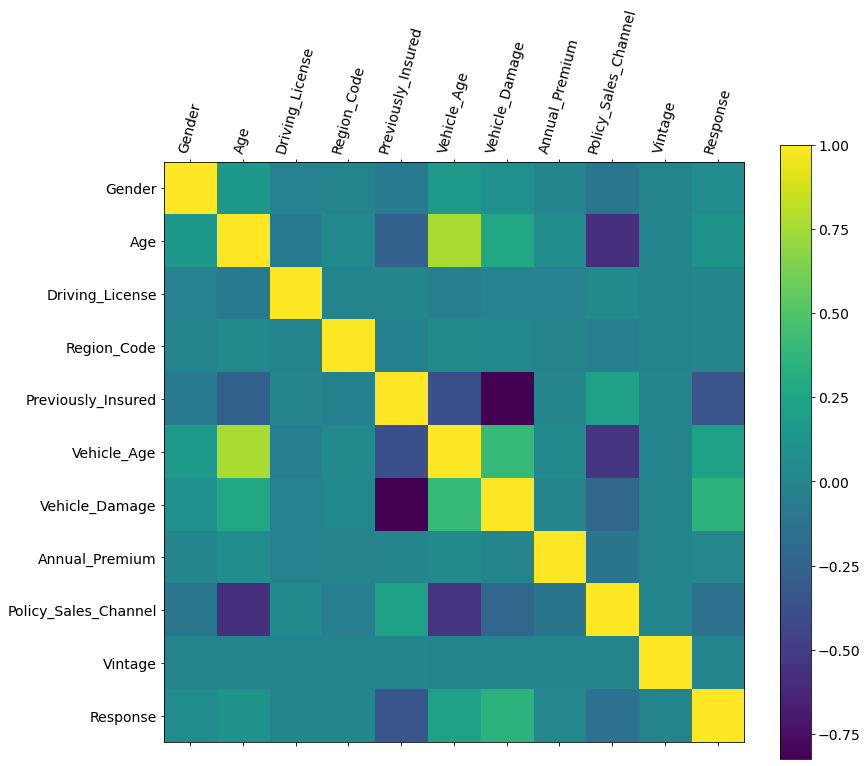

In [ ]:
f = plt.figure(
    figsize=(13, 11)
)

plt.matshow(
    train.corr(), 
    fignum=f.number
)

plt.xticks(
    range(train.shape[1]), 
    train.columns, 
    fontsize=14, 
    rotation=75
)

plt.yticks(
    range(train.shape[1]), 
    train.columns, 
    fontsize=14
)

cb = plt.colorbar()

cb.ax.tick_params(
    labelsize=14
)

Correlation for every feature with target

In [ ]:
for col in train.columns:
    if col == 'Response':
        continue
    print(col, train[col].corr(train['Response']))

Gender 0.05243991377134212
Age 0.11114689471250998
Driving_License 0.01015517459407383
Region_Code 0.01056985561522315
Previously_Insured -0.3411704626135235
Vehicle_Age 0.22187398721799095
Vehicle_Damage 0.35439954387975714
Annual_Premium 0.02257469554256
Policy_Sales_Channel -0.13904150082916103
Vintage -0.001050372001989886


<a id="3"></a>
<h2 style='background:blue; border:0; color:white'><center>3. Modeling</center><h2>

In [ ]:
X = train.drop(['Response'], axis=1)
y = train['Response']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print('Positive cases % in validation set: ', round(100 * len(y_test[y_test == 1]) / len(y_test), 3), '%')
print('Positive cases % in train set: ', round(100 * len(y_train[y_train == 1]) / len(y_train), 3), '%')

Positive cases % in validation set:  12.494 %
Positive cases % in train set:  12.197 %


So we can see that our sets are well balanced by target column and we can use our validation set for testing.

In [ ]:
def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

In [ ]:
# def recall_score(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_score(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def keras_f1_score(y_true, y_pred):
#     precision = precision_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

Anything above is taken from the Kaggle Website with editing as we see appropriate

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
def create_base_model():
    tf.keras.utils.set_random_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(10),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[recall_score]
    )
    return model

In [ ]:
y_nn_train = to_categorical(y_train)


In [ ]:
y_nn_train


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
y_train

332803    1.0
116248    0.0
255005    0.0
317474    0.0
344212    0.0
         ... 
259178    0.0
365838    0.0
131932    0.0
146867    0.0
121958    1.0
Name: Response, Length: 304887, dtype: float32

In [ ]:
class_weight = {
    0: 1.,
    1: 8.
}

In [ ]:
model = create_base_model()
history_base = model.fit(X_train, y_nn_train, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight)

Epoch 1/35
953/953 - 10s - loss: 0.9007 - recall_score: 0.6480 - val_loss: 0.5324 - val_recall_score: 0.6433 - 10s/epoch - 11ms/step
Epoch 2/35
953/953 - 4s - loss: 0.8117 - recall_score: 0.6684 - val_loss: 0.5112 - val_recall_score: 0.6720 - 4s/epoch - 4ms/step
Epoch 3/35
953/953 - 4s - loss: 0.8054 - recall_score: 0.6736 - val_loss: 0.4850 - val_recall_score: 0.6751 - 4s/epoch - 5ms/step
Epoch 4/35
953/953 - 4s - loss: 0.8048 - recall_score: 0.6735 - val_loss: 0.4959 - val_recall_score: 0.6756 - 4s/epoch - 4ms/step
Epoch 5/35
953/953 - 4s - loss: 0.8036 - recall_score: 0.6738 - val_loss: 0.5154 - val_recall_score: 0.6648 - 4s/epoch - 4ms/step
Epoch 6/35
953/953 - 6s - loss: 0.7997 - recall_score: 0.6756 - val_loss: 0.5014 - val_recall_score: 0.6816 - 6s/epoch - 6ms/step
Epoch 7/35
953/953 - 4s - loss: 0.8000 - recall_score: 0.6769 - val_loss: 0.5061 - val_recall_score: 0.6739 - 4s/epoch - 4ms/step
Epoch 8/35
953/953 - 4s - loss: 0.7987 - recall_score: 0.6766 - val_loss: 0.5022 - val_

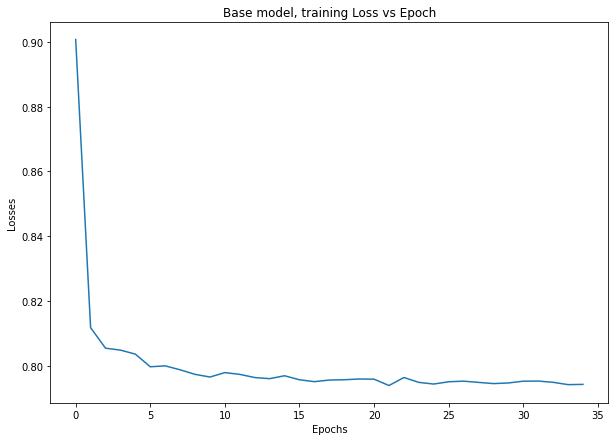

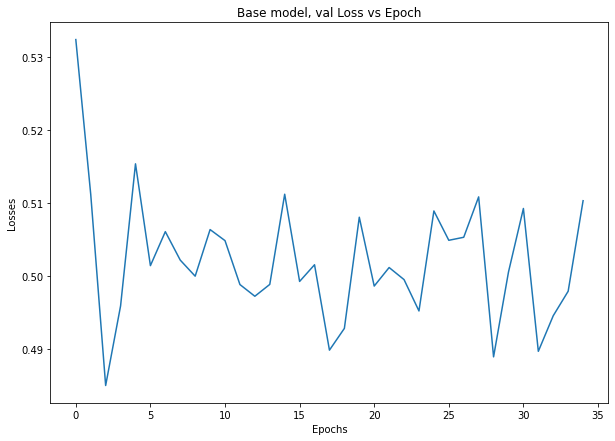

In [ ]:
plt.figure(figsize =(10,7))
plt.plot(history_base.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Base model, training Loss vs Epoch")
plt.show()

plt.figure(figsize =(10,7))
plt.plot(history_base.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Base model, val Loss vs Epoch")
plt.show()

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)

2382/2382 [==============================] - 4s 2ms/step


In [ ]:
print('base NN recall: ', recall_score(y_test.astype('float32'), preds.astype('float32')))

base NN recall:  tf.Tensor(0.95621127, shape=(), dtype=float32)


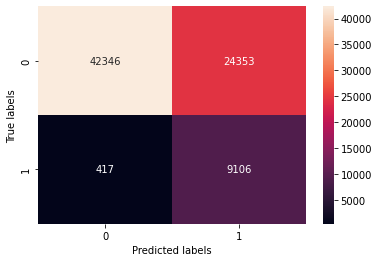

In [ ]:
plot_confusion_matrix(y_test, preds)

Above cells define the base model taken from Kaggle website.
It is observed that the training loss is stable while the validation loss is fluctuating after 5-10 epochs.

As for the base model, 
the number of False Negative is 487,
the number of True Positive is 9036,
and the recall score is 0.9488606531555183.


Below cells are from our attempts to fine tune hyper-parameters

In [ ]:
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None
    tf.keras.utils.set_random_seed(42)
    if optimizer_name == 'adagrad': 
        optimizer = tf.keras.optimizers.legacy.Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)

    elif'adam' :
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        
    elif 'SGD':
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
            
    return optimizer

In [ ]:
def create_multi_models(op, epoch, bs):
    tf.random.set_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(10),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=op,
        metrics=['Recall']
    )
    
    model.fit(X_train, y_nn_train, validation_split=0.2, epochs=epoch, batch_size=bs, verbose=2, class_weight=class_weight)


    return model

In [ ]:
learning_rate = [0.001, 0.0005]
batch_size = [1024, 2048, 4096]
optimizers = ['adam','rmsprop','SGD','adagrad']

Model_pool = []
lr_flatten = []
batch_size_flatten = []
optimizers_flatten = []

for lr in learning_rate:
  for op in optimizers:
    opt = get_optimizer(op, lr)
    for bs in batch_size:
      model = create_multi_models(opt, 25, bs)
      Model_pool.append(model)
      lr_flatten.append(lr)
      batch_size_flatten.append(bs)
      optimizers_flatten.append(op)



Epoch 1/25
239/239 - 2s - loss: 0.9971 - recall: 0.6267 - val_loss: 0.4858 - val_recall: 0.6392 - 2s/epoch - 9ms/step
Epoch 2/25
239/239 - 1s - loss: 0.8346 - recall: 0.6592 - val_loss: 0.5123 - val_recall: 0.6502 - 1s/epoch - 5ms/step
Epoch 3/25
239/239 - 2s - loss: 0.8135 - recall: 0.6670 - val_loss: 0.5140 - val_recall: 0.6528 - 2s/epoch - 7ms/step
Epoch 4/25
239/239 - 1s - loss: 0.8075 - recall: 0.6708 - val_loss: 0.4898 - val_recall: 0.6793 - 1s/epoch - 4ms/step
Epoch 5/25
239/239 - 1s - loss: 0.8041 - recall: 0.6745 - val_loss: 0.5166 - val_recall: 0.6614 - 1s/epoch - 4ms/step
Epoch 6/25
239/239 - 1s - loss: 0.8030 - recall: 0.6741 - val_loss: 0.5008 - val_recall: 0.6750 - 1s/epoch - 4ms/step
Epoch 7/25
239/239 - 1s - loss: 0.8022 - recall: 0.6745 - val_loss: 0.4982 - val_recall: 0.6693 - 1s/epoch - 4ms/step
Epoch 8/25
239/239 - 1s - loss: 0.8009 - recall: 0.6754 - val_loss: 0.4993 - val_recall: 0.6786 - 1s/epoch - 4ms/step
Epoch 9/25
239/239 - 1s - loss: 0.8001 - recall: 0.6760 

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adam, batch_size 1024, learning rate 0.001| recall score:0.9561


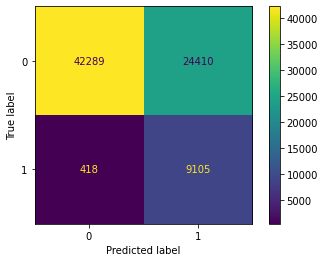

2382/2382 [==============================] - 5s 2ms/step
Current NN: Optimizer adam, batch_size 2048, learning rate 0.001| recall score:0.9546


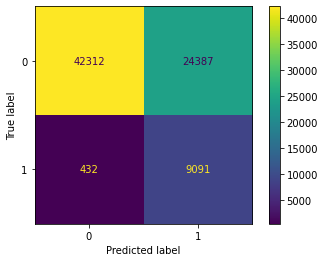

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adam, batch_size 4096, learning rate 0.001| recall score:0.9511


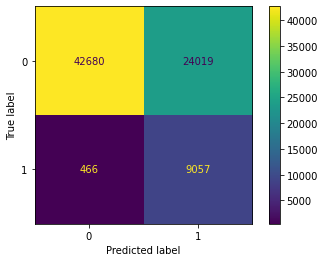

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer rmsprop, batch_size 1024, learning rate 0.001| recall score:0.9566


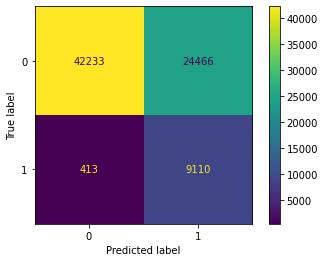

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer rmsprop, batch_size 2048, learning rate 0.001| recall score:0.9548


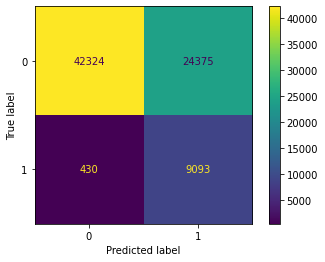

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer rmsprop, batch_size 4096, learning rate 0.001| recall score:0.9506


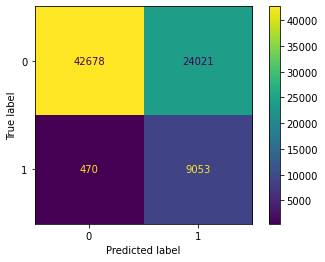

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer SGD, batch_size 1024, learning rate 0.001| recall score:0.9554


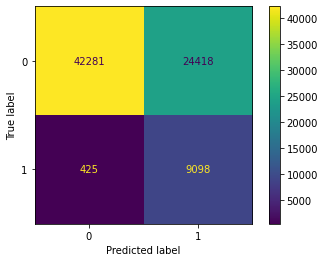

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer SGD, batch_size 2048, learning rate 0.001| recall score:0.9544


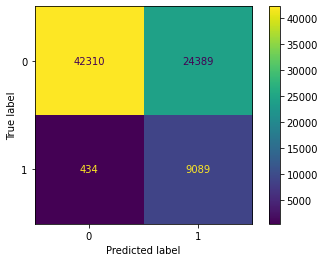

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer SGD, batch_size 4096, learning rate 0.001| recall score:0.9509


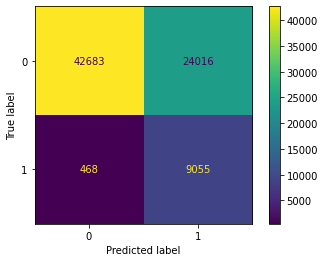

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adagrad, batch_size 1024, learning rate 0.001| recall score:0.9799


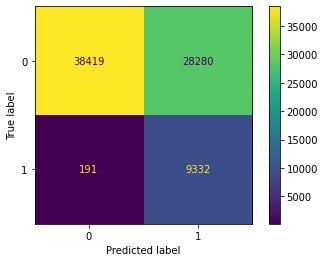

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adagrad, batch_size 2048, learning rate 0.001| recall score:0.982


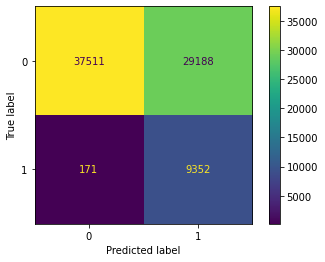

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adagrad, batch_size 4096, learning rate 0.001| recall score:0.9791


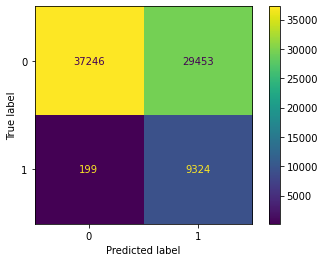

2382/2382 [==============================] - 5s 2ms/step
Current NN: Optimizer adam, batch_size 1024, learning rate 0.0005| recall score:0.9523


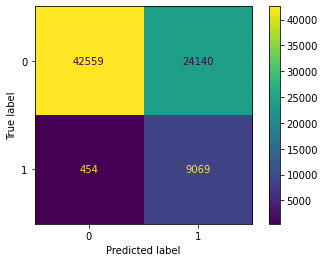

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adam, batch_size 2048, learning rate 0.0005| recall score:0.9512


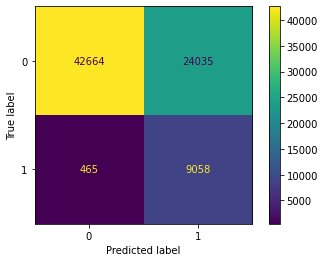

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adam, batch_size 4096, learning rate 0.0005| recall score:0.952


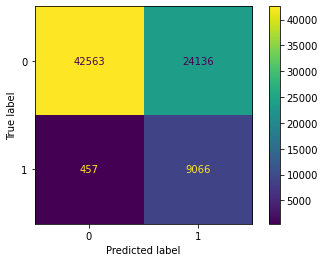

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer rmsprop, batch_size 1024, learning rate 0.0005| recall score:0.9519


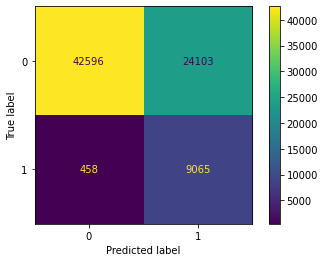

2382/2382 [==============================] - 5s 2ms/step
Current NN: Optimizer rmsprop, batch_size 2048, learning rate 0.0005| recall score:0.9511


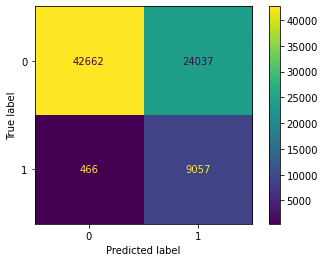

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer rmsprop, batch_size 4096, learning rate 0.0005| recall score:0.952


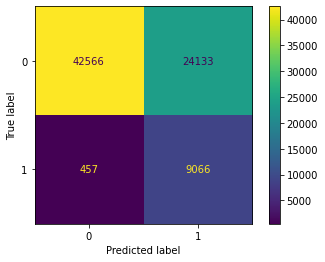

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer SGD, batch_size 1024, learning rate 0.0005| recall score:0.9519


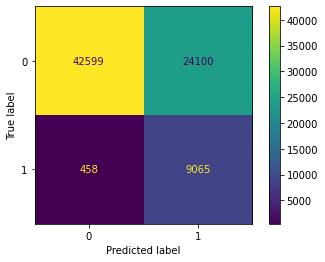

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer SGD, batch_size 2048, learning rate 0.0005| recall score:0.9512


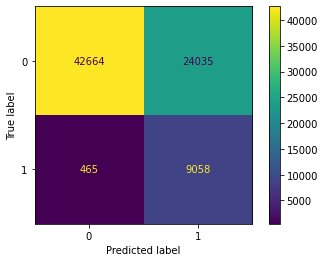

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer SGD, batch_size 4096, learning rate 0.0005| recall score:0.952


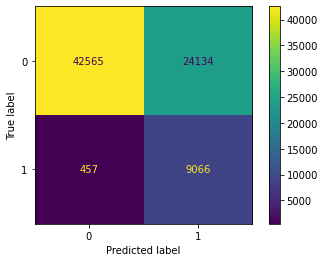

2382/2382 [==============================] - 5s 2ms/step
Current NN: Optimizer adagrad, batch_size 1024, learning rate 0.0005| recall score:0.9837


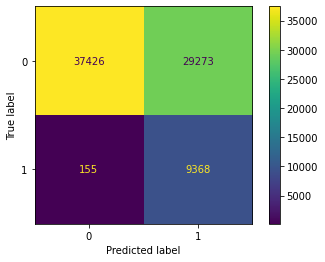

2382/2382 [==============================] - 4s 2ms/step
Current NN: Optimizer adagrad, batch_size 2048, learning rate 0.0005| recall score:0.9629


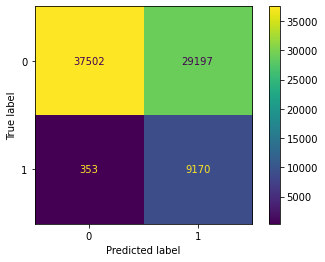

2382/2382 [==============================] - 5s 2ms/step
Current NN: Optimizer adagrad, batch_size 4096, learning rate 0.0005| recall score:0.9266


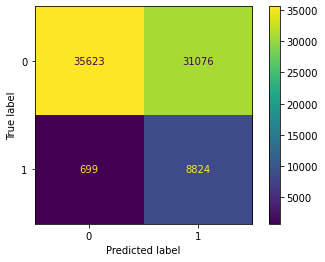

In [ ]:
recall_score_list = []

for model, lr, bs, op in zip(Model_pool, lr_flatten, batch_size_flatten, optimizers_flatten):
      preds = model.predict(X_test)
      preds = np.argmax(preds, axis=1)
      ## report r_score
      r_score = round(recall_score(tf.cast(y_test, tf.float32), tf.cast(preds, tf.float32)),4)
      recall_score_list.append(r_score)
      print(f'Current NN: Optimizer {op}, batch_size {bs}, learning rate {lr}| recall score:' + str(r_score))

      #plot confusion matrix
      cm = confusion_matrix(y_test, preds, labels=[0,1])
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
      disp.plot()
      plt.show() 


In [ ]:
r_score_table = pd.concat((pd.DataFrame(optimizers_flatten), pd.DataFrame(lr_flatten), pd.DataFrame(batch_size_flatten), pd.DataFrame(recall_score_list)), axis =1)
r_score_table.columns = ["Optimizer", "learning_rate", "batch_size", "Recall score"]
r_score_table.head(100)

,Optimizer,learning_rate,batch_size,Recall score
0,adam,0.0010,1024,0.9561
1,adam,0.0010,2048,0.9546
2,adam,0.0010,4096,0.9511
3,rmsprop,0.0010,1024,0.9566
4,rmsprop,0.0010,2048,0.9548
5,rmsprop,0.0010,4096,0.9506
6,SGD,0.0010,1024,0.9554
7,SGD,0.0010,2048,0.9544
8,SGD,0.0010,4096,0.9509
9,adagrad,0.0010,1024,0.9799


In [ ]:
def create_multi_models_plot(op, epoch, bs):
    tf.keras.utils.set_random_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(10),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=op,
        metrics=['Recall']
    )

    history = model.fit(X_train, y_nn_train, validation_split=0.2, epochs=epoch, batch_size=bs, verbose=0, class_weight=class_weight)


    return history

In [ ]:
# for loss in ("loss", "val_loss"):
#   plt.figure(figsize=(20, 20))
#   for lr in learning_rate:
#     for op in optimizers:
#       opt = get_optimizer(op, lr)
#       for bs in batch_size:
#         history = create_multi_models_plot(opt, 25, bs)
#         plt.plot(history.history["loss"], label = f'Opt {op}, bs {bs}, lr{lr}')
#   plt.xlabel("Epochs")
#   plt.ylabel(loss)
#   plt.title(f'{loss} against epochs')
#   plt.legend(loc="upper left")
#   plt.show()      

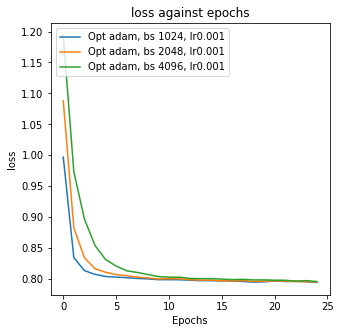

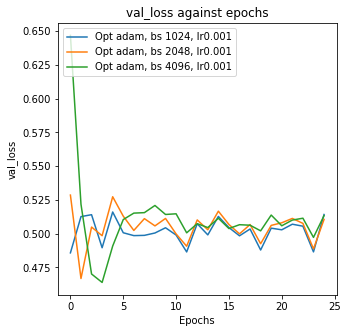

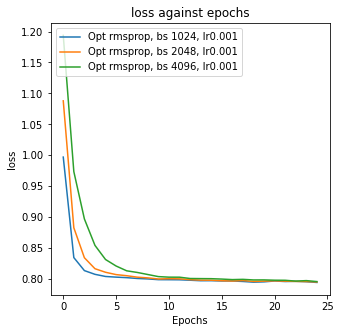

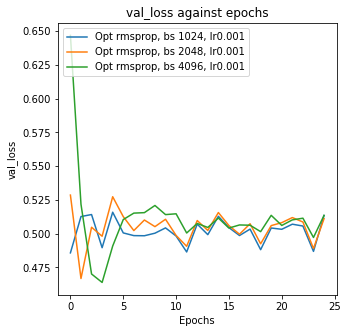

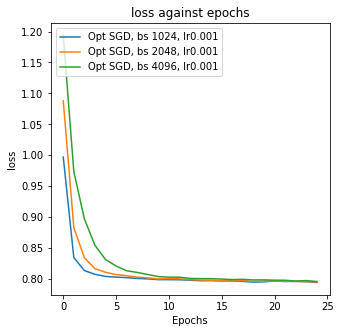

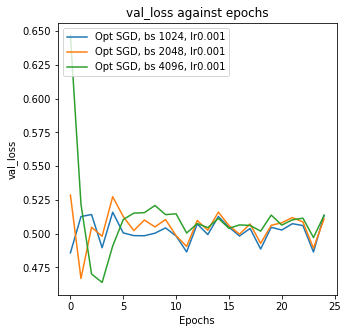

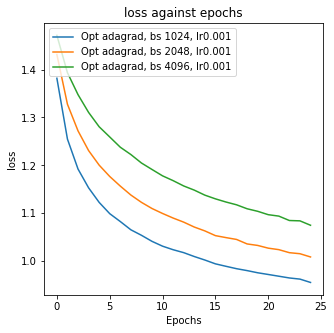

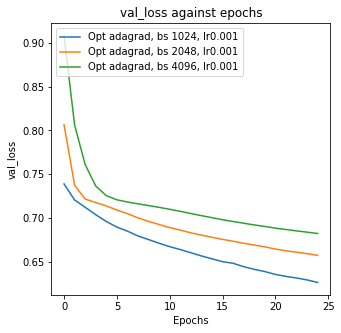

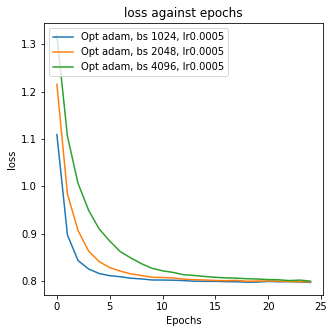

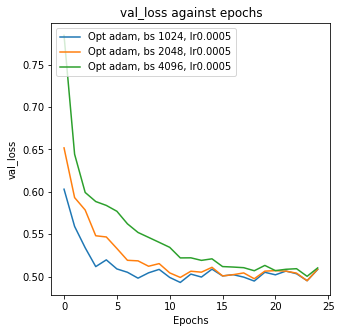

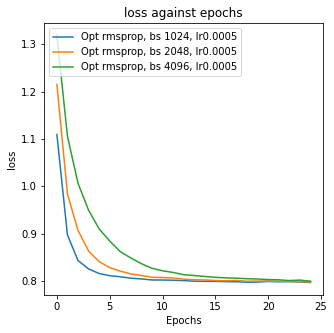

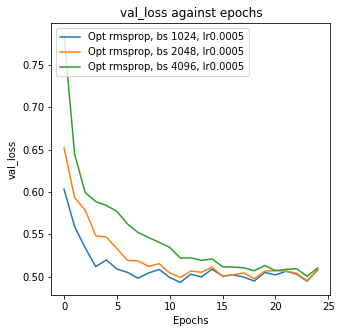

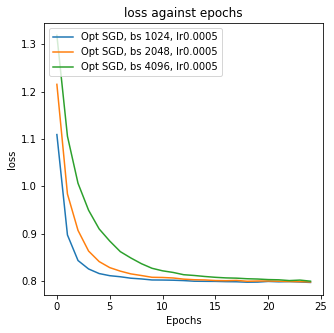

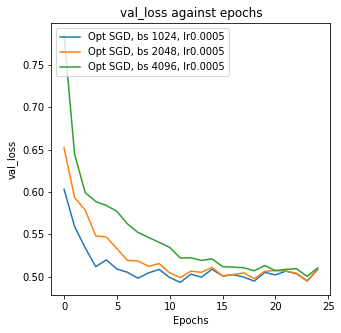

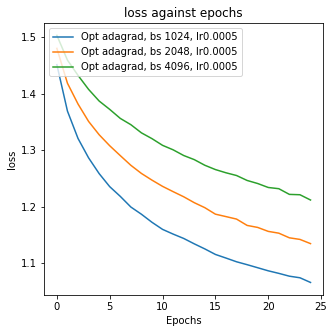

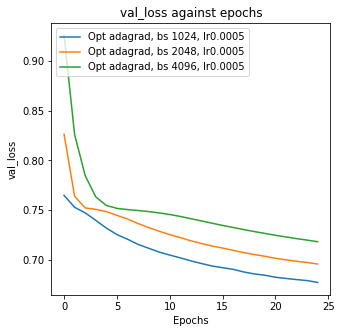

In [ ]:
### plot the impact of batch size
loss_history = []
  
for lr in learning_rate:
  for op in optimizers:
    opt = get_optimizer(op, lr)
    for loss in ("loss", "val_loss"):
      plt.figure(figsize=(5, 5))
      for bs in batch_size:
        history = create_multi_models_plot(opt, 25, bs)
        loss_history.append(history)
        plt.plot(history.history[loss], label = f'Opt {op}, bs {bs}, lr{lr}')
      plt.xlabel("Epochs")
      plt.ylabel(loss)
      plt.title(f'{loss} against epochs')
      plt.legend(loc="upper left")
      plt.show()      

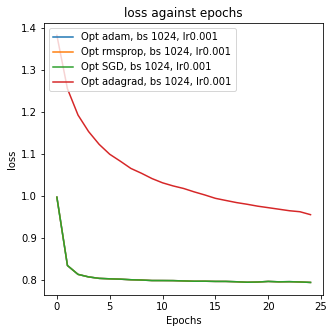

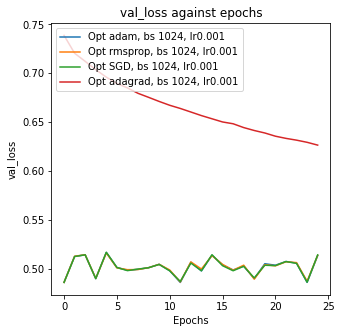

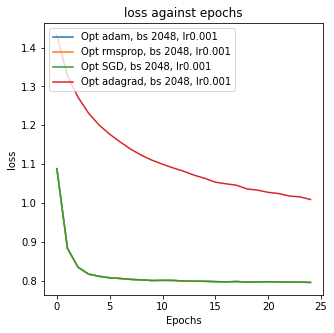

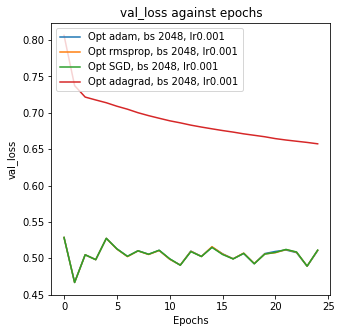

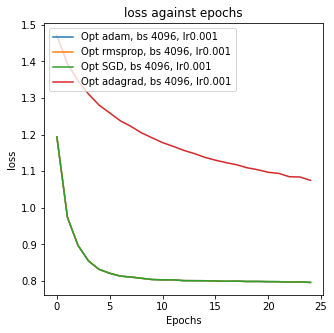

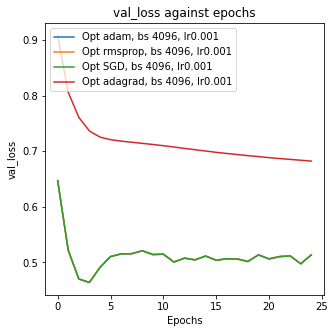

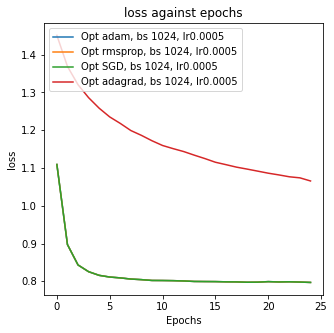

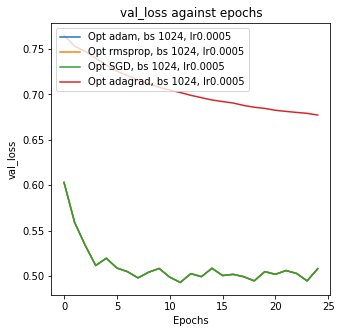

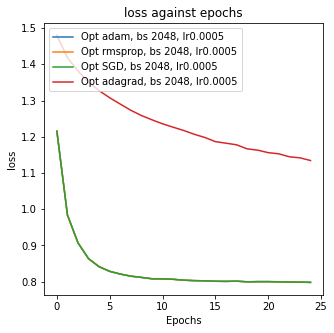

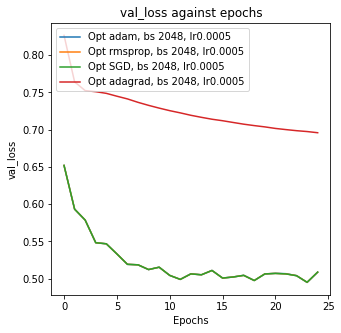

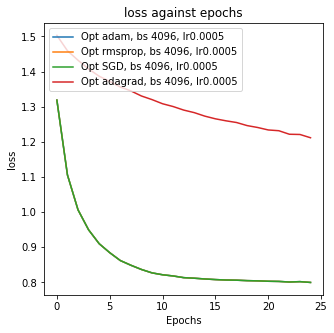

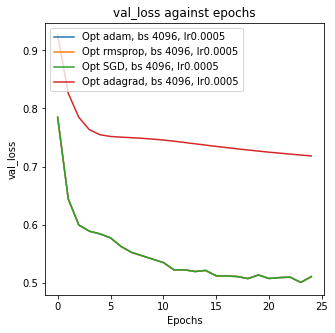

In [ ]:
### plot the impact of optimizers
for lr in learning_rate:
  for bs in batch_size:
    for loss in ("loss", "val_loss"):
      plt.figure(figsize=(5, 5))

      for op in optimizers:
        opt = get_optimizer(op, lr)
        history = create_multi_models_plot(opt, 25, bs)
        loss_history.append(history)
        plt.plot(history.history[loss], label = f'Opt {op}, bs {bs}, lr{lr}')
      plt.xlabel("Epochs")
      plt.ylabel(loss)
      plt.title(f'{loss} against epochs')
      plt.legend(loc="upper left")
      plt.show()      

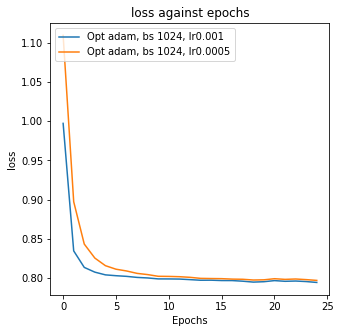

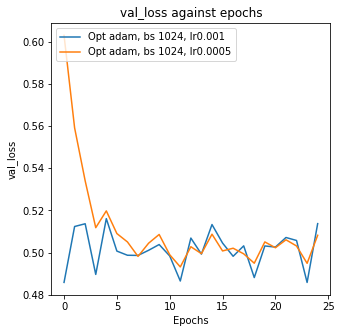

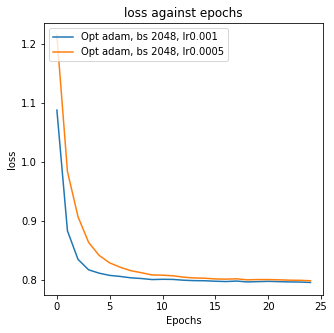

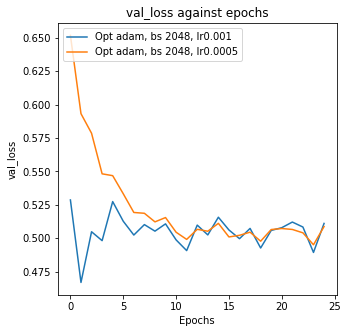

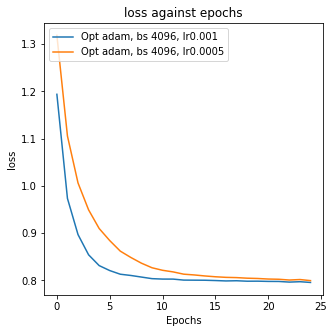

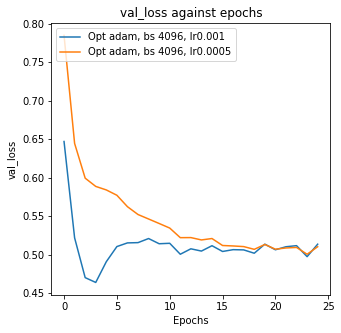

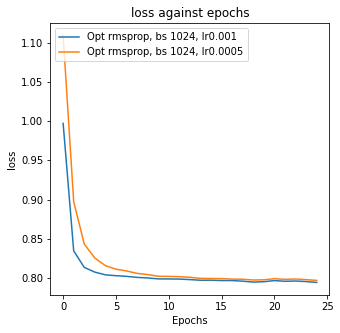

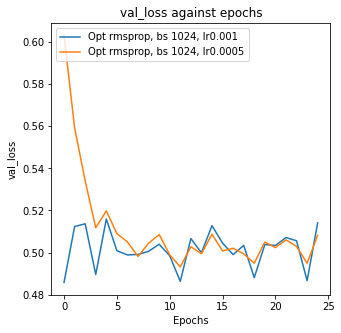

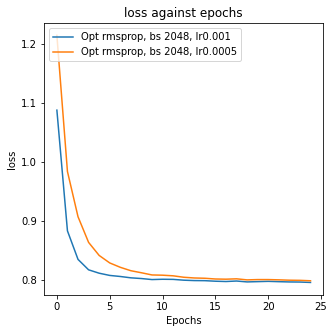

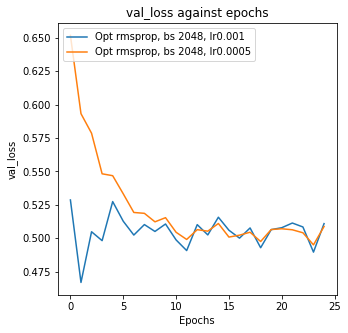

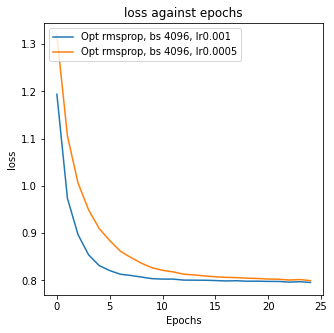

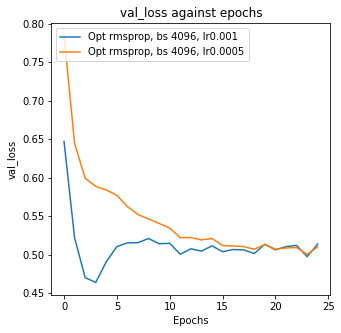

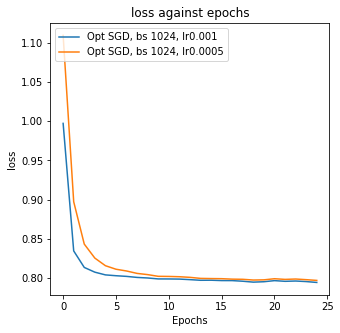

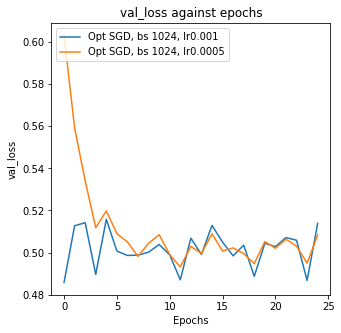

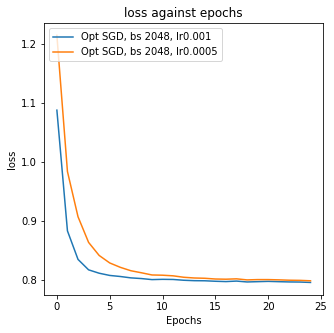

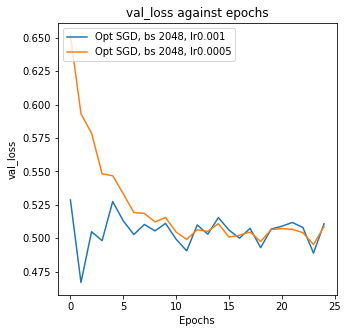

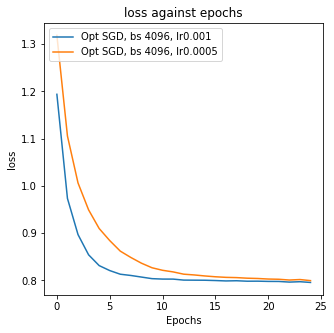

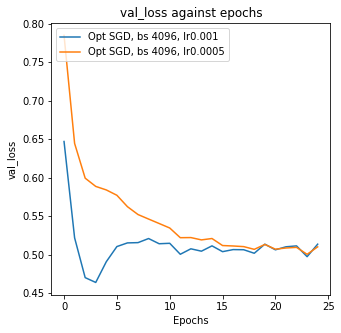

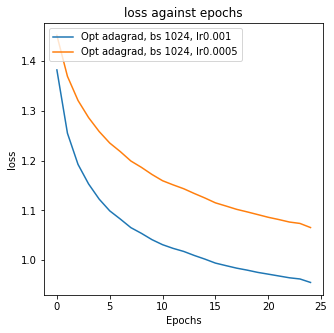

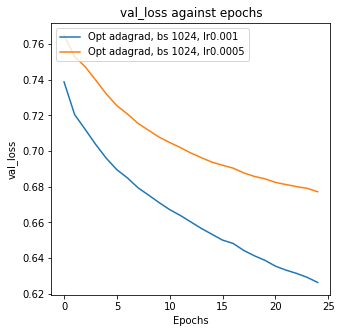

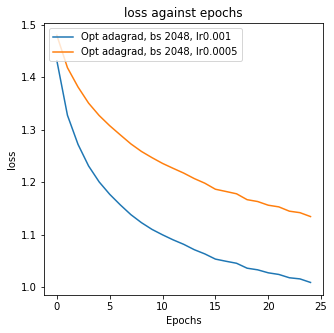

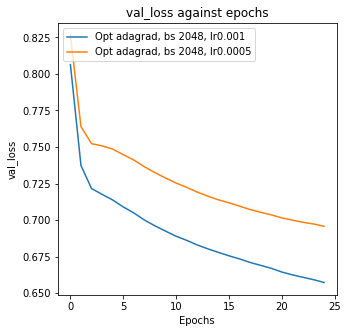

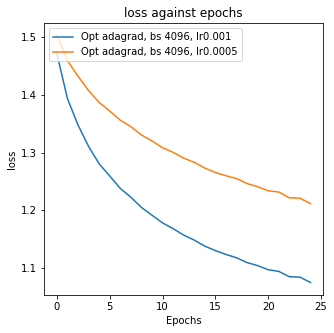

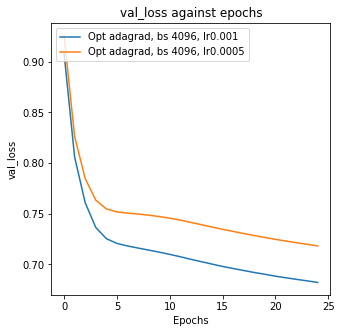

In [ ]:
### plot the impact of learning rate

for op in optimizers:
  for bs in batch_size:
    for loss in ("loss", "val_loss"):
      plt.figure(figsize=(5, 5))

      for lr in learning_rate:
        opt = get_optimizer(op, lr)
        history = create_multi_models_plot(opt, 25, bs)
        loss_history.append(history)
        plt.plot(history.history[loss], label = f'Opt {op}, bs {bs}, lr{lr}')
      plt.xlabel("Epochs")
      plt.ylabel(loss)
      plt.title(f'{loss} against epochs')
      plt.legend(loc="upper left")
      plt.show()      

<a id="2"></a>
<h2 style='background:blue; border:0; color:white'><center>Result discussion</center><h2>

For evaluating the impact of batch size under the same optimizer, the higher the batch size, more epochs are required for loss function to achieve convergence. these happened in the case of using adam, rmsprop and SGD.

however, in adagrad, with the rate of change of the loss function seems even slower, which means it need even more time for the convergence.

As for impact of the optimizer, we expect ADAM to be the best performing one. However, it turns out that Adagrad is better despite its validation loss is still not flatten after 25 epochs. As a next step, it is recommended to explore further the impact of Epoch on this model specifically to identify potential improvement.




As for impact of the learning rate , there is no significat impact of changing learnign rate on adam rmsprop and SGD on the validation set, except for adagrad because the number of epochs is not enough for adagrad to achieve convergence, which is consistent with the observation above. 

Comparing to this list of confusion matrix, our best model with the highest Recall Score is the one with adagrad being the optimizer,using 0.0005 and 1024 for the learning rate and batch size respectively.

So conclusion, compared with the base model , our best model could achieve the recall score as 0.9837.

<a id="2"></a>
<h2 style='background:blue; border:0; color:white'><center>Conclusion</center><h2>

Based on the observations above, the model with adagrad as optimizer performed better in general. However, based on the graph of loss against epoch, the adagrad does not show flattening of validation loss. This may suggest that even though our best model is from adagrad, there could be still room for further improvement.

Last but not least, it is surprising to see adagrad perform better than ADAM given ADAM is the combination of Adagrad and RMSprop and have the advantage of both optimizers.